# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


### Import Modules and Read Dataset

In [358]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

In [359]:
df = pd.read_csv('../../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
df.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,CRS_ARR_M,Temperature,Dew Point,Humidity,...,Condition_Light Snow / Windy,Condition_Mostly Cloudy,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Snow,Condition_Wintry Mix,Condition_Wintry Mix / Windy
0,11,1,5,124,636,324,448,48,34,58,...,False,False,False,False,False,False,False,False,False,False
1,11,1,5,371,2475,340,531,48,34,58,...,False,False,False,False,False,False,False,False,False,False
2,11,1,5,181,1069,301,482,48,34,58,...,False,False,False,False,False,False,False,False,False,False
3,11,1,5,168,944,345,513,48,34,58,...,False,False,False,False,False,False,False,False,False,False
4,11,1,5,139,760,360,499,46,32,58,...,False,False,False,False,False,False,False,False,False,False


In [360]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Columns: 111 entries, MONTH to Condition_Wintry Mix / Windy
dtypes: int64(111)
memory usage: 24.4 MB


### Outilers Testing

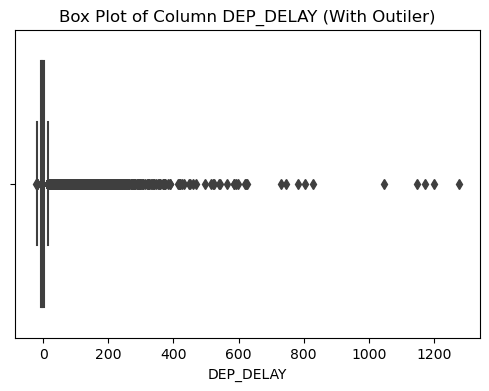

In [361]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['DEP_DELAY'])
plt.title("Box Plot of Column DEP_DELAY (With Outiler)")
plt.show()

Skewness of DEP_DELAY: 4.820893338359548


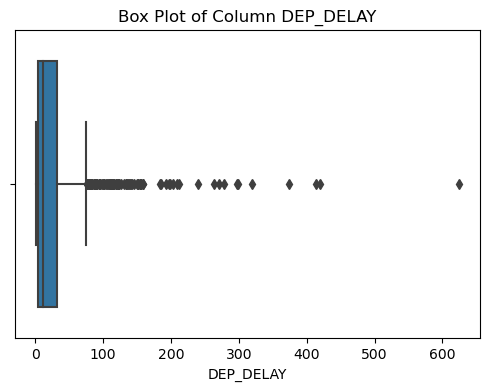

In [362]:
# Spliting the dataset
# Getting DEP_DELAY for the once only delay 
# any positive values means that it is early departure

df = df[df['DEP_DELAY'] > 0]
df = df.head(1000) #sampling the first 1000 dataset

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])

print(f"Skewness of DEP_DELAY: {df['DEP_DELAY'].skew()}")  # If > 0.5 or < -0.5, transformation is needed
# print(df['DEP_DELAY_shifted'].skew())  # If > 0.5 or < -0.5, transformation is needed

plt.figure(figsize=(6,4))
sns.boxplot(x=df['DEP_DELAY'])
plt.title("Box Plot of Column DEP_DELAY")
plt.show()
# 

In [363]:
X = df.drop(columns=['DEP_DELAY', ]) #Dropping DEP_DELAY Log/Sqrt transform cols

X = df.drop(columns=['DEP_DELAY']) #Dropping DEP_DELAY Log/Sqrt transform cols

y = df['DEP_DELAY']
# y = df['DEP_DELAY_shifted']

y.head(3)

2      40
9       3
14    108
Name: DEP_DELAY, dtype: int64

### Feature Selection

In [364]:
X = X.applymap(lambda x: max(x, 0))
X = X.fillna(X.mean())

/var/folders/06/6rnd9mvj2tg64m2vg9cssn0w0000gn/T/ipykernel_25791/3256436071.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: max(x, 0))


In [365]:
k_num_features = 5  # Number of top features to select

In [366]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features 
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)

Selected Features:
                Feature    F-Score
1              DISTANCE  28.007658
0      CRS_ELAPSED_TIME  26.175560
3               sch_dep  20.889370
2              Pressure  20.543771
4  OP_UNIQUE_CARRIER_OO  17.747460


### Split Training and Test Data 80:20

In [367]:
from sklearn.model_selection import train_test_split 
# X needs to be updated 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 42)

In [368]:
# Compute IQR
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter out outliers
X_train = X_train[(X_train >= lower_bound) & (X_train <= upper_bound)]

# Remove rows with NaN values from both X_train and y_train
X_train, y_train = X_train.align(y_train, join='inner', axis=0)

X_train_zero = X_train[(X_train == 0)]
type(X_train_zero['DISTANCE'])


pandas.core.series.Series

In [369]:
print(X_train[(X_train == Nan)])

NameError: name 'Nan' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=9, metric='manhattan', weights='distance')
regressor.fit(X_train, y_train)

ValueError: Input X contains NaN.
KNeighborsRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Results (MSE, MAE,  Predic vs Acutal Graph)

In [ ]:
y_pred = regressor.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Average Prediction {np.mean(y_pred)}")

# print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 2374.26
Average Prediction 27.286569752866612


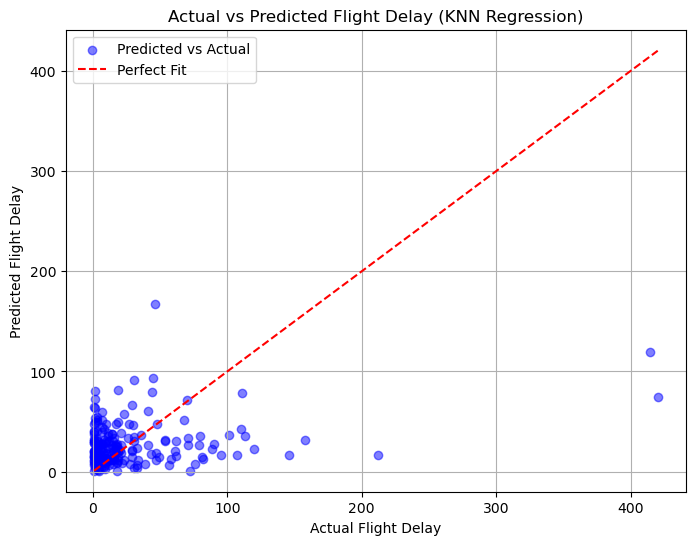

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()

### Grid Search 

To find the best k value for knn

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(3, 11, 2)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best k:", grid.best_params_)

Best k: {'n_neighbors': 9}
